In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from math import pi, exp, log10, sqrt, log
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
class FirstOlderForward:
    
    # constant parameters used in computing
    _c1 =  1.211243
    _c2 = -0.08972168
    _c3 =  0.001384277
    _c4 = -0.00176566
    _c5 =  0.0001186795
    
    # model parameters
    _pmodel = None
    _vpmodel = None
    _vsmodel = None
    _c11 = None   # = c33 = λ+ 2μ
    _c13 = None   # = λ
    _c44 = None   # = μ
    _vx = None
    _vx = None
    _dt = 0
    _dx = 0
    _dz = 0
    _nt = 0
    _nx = 0
    _nz = 0
    _tmax = 0
    _xmax = 0
    _zmax = 0
    
    def __init__(self, pmodel=None, vpmodel=None, vsmodel=None, tmax=1., xmax=1000., zmax=800., nt=1000, nx=100, nz=80):

        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)

    # forward modeling operator with precion of O(4,10)
    def o4xFM(self, wavelet, wavalet_position, wavalet_direction='z'):
        
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        
        # start to compute
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o4xComputeVx(u, v, r, t, h)
                v = self.o4xComputeVz(u, v, r, t, h)
                r = self.o4xComputeTauxx(u ,v, r, t, h)
                t = self.o4xComputeTauzz(u ,v, r, t, h)
                h = self.o4xComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                    else:
                        v[wavalet_position[0], wavalet_position[1]] += wavelet[tk] 
                
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
                
            if tk % 100 == 99:
                print("The " + str(tk) + " times result of v_x near the source position")
                print(u[wavalet_position[1]-3:wavalet_position[0]+4, wavalet_position[1]-3:wavalet_position[0]+4])
      
    # function to oompute the velocity in x axis of the next time step
    def o4xComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [0, self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        one = self._dt / (self._dx * self._pmodel) * convolve(r, kernal, mode='same', method='direct')
        
        # compute the 2nd item
        kernal = kernal.T
        two = self._dt / (self._dz * self._pmodel) * convolve(h, kernal, mode='same', method='direct')
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c11 / (24 * self._pmodel**2 * self._dx**3) * convolve(r, kernal, mode='same', method='direct')
        
        # compute the 4th item
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dz * self._dx**2) * convolve(h, kernal, mode='same', method='direct')
        
        # compute the 5th item
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(t, kernal, mode='same', method='direct')      
        
        # compute the 6th item
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(r, kernal, mode='same', method='direct')  
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        kernal[2, :] = [0, 1, -3, 3, -1]
        seven = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(h, kernal, mode='same', method='direct')
        
        # sum all
        output = u + one + two + three + four + five + six + seven
        
        return output    
    
    # function to oompute the velocity in z axis of the next time step
    def o4xComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11,11),dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5, 0]      
        one = self._dt / (self._dx * self._pmodel) * convolve(h, kernal, mode='same', method='direct')
        
        # compute the 2nd item
        kernal = kernal.T
        two = self._dt / (self._dz * self._pmodel) * convolve(t, kernal, mode='same')
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c44 / (24 * self._pmodel**2 * self._dx**3) * convolve(h, kernal, mode='same', method='direct')
        
        # compute the 4th item
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dx * self._dz**2) * convolve(h, kernal, mode='same', method='direct')
        
        # compute the 5th item
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(r, kernal, mode='same', method='direct')      
        
        # compute the 6th item
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(t, kernal, mode='same', method='direct')
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        kernal[2,:] = [1, -3, 3, -1, 0]
        seven = self._dt**3 * self._c11 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(t, kernal, mode='same', method='direct')
        
        # sum all
        output = v + one + two + three + four + five + six + seven
        
        return output

    # function to oompute the stress on xx
    def o4xComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11,11),dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5, 0]      
        one = self._dt * self._c11 / self._dx * convolve(u, kernal, mode='same', method='direct')
        
        # compute the 2nd item
        kernal = np.zeros((11,11),dtype=float)
        kernal[5,:] = [0, self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]   
        two = self._dt * self._c13 / self._dz * convolve(v, kernal, mode='same', method='direct')
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same', method='direct')
        
        # computer the 4th item
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c11*self._c13 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same', method='direct')  
        
        # computer the 5th item
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same', method='direct')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11* self._c13 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same', method='direct')
        
        # sum all
        output = r + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on zz
    def o4xComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11,11),dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5, 0]     
        one = self._dt * self._c13 / self._dx * convolve(u, kernal, mode='same', method='direct')
        
        # compute the 2nd item
        kernal = np.zeros((11,11),dtype=float)
        kernal[5,:] = [0, self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]            
        two= self._dt * self._c11 / self._dz * convolve(v, kernal, mode='same', method='direct')
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11 * self._c13 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same', method='direct')
        
        # computer the 4th item
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c13**2 + self._c13*self._c44 + self._c11*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same', method='direct')  
        
        # computer the 5th item
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13 * self._c11 + self._c13 * self._c44 + self._c11 * self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same', method='direct')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same', method='direct')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on xz
    def o4xComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11),dtype=float)
        kernal[:,5] = [0, self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]     
        one = self._dt * self._c44 / self._dx * convolve(v, kernal, mode='same', method='direct')
        
        # compute the 2nd item
        kernal = np.zeros((11,11),dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5, 0]   
        two = self._dt * self._c44 / self._dz * convolve(u, kernal, mode='same', method='direct')
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dx**3) * convolve(v, kernal, mode='same', method='direct')
        
        # computer the 4th item
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        four = self._dt**3 * (self._c44**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(u, kernal, mode='same', method='direct')  
        
        # computer the 5th item
        kernal = np.array([[0,0,0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * self._c44 * (self._c13 + self._c44 + self._c11) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(v, kernal, mode='same', method='direct')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        kernal[2, :] = [1, -3, 3, -1, 0]
        six = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dz**3) * convolve(u, kernal, mode='same', method='direct')
        
        # sum all
        output = h + one + two + three + four + five + six
        
        return output
    
    def DrawModel(self):
        if self._nx > self._nz:
            plt.figure(figsize=(20, 4))
        elif self._nx == self._nz:
            plt.figure(figsize=(20, 6))
        else:
            plt.figure(figsize=(20, 8))
        
        ax1 = plt.subplot(1,3,1)
        plt.imshow(self._pmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("density model")
        plt.colorbar(shrink=0.8)
        
        plt.subplot(1,3,2)
        plt.imshow(self._vpmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("P wave velocity model")
        plt.colorbar(shrink=0.8)

        plt.subplot(1,3,3)
        plt.imshow(self._vsmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("S wave velocitydensity model")
        plt.colorbar(shrink=0.8)
        
    def RangeInOne(self, array):
        _max = max(np.max(array), abs(np.min(array)))
        return array / _max        

    def DrawWaveField(self):
        iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='quadric ', aspect='auto')
            ax.annotate("t = {0} ms".format(iterations_to_show[j] * self._dt), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawXWaveField(self, iterations_to_show):
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j] * self._dt), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawZWaveField(self, iterations_to_show):
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vz[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    
    def o22FM(self, wavelet, wavalet_position, wavalet_direction='z'): 
        
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o22ComputeVx(u, v, r, t, h)
                v = self.o22ComputeVz(u, v, r, t, h)
                r = self.o22ComputeTauxx(u ,v, r, t, h)
                t = self.o22ComputeTauzz(u ,v, r, t, h)
                h = self.o22ComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]

            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
            if tk % 100 == 99:
                print("The " + str(tk) + " times result of v_x near the source position")
                print(u[wavalet_position[1]-3:wavalet_position[0]+4, wavalet_position[1]-3:wavalet_position[0]+4])
                
    def o22ComputeVx(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same', method='direct')
        
        output = u + one + two
        
        return output
        
    def o22ComputeVz(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same', method='direct')
        
        output = v + one + two
               
        return output

    def o22ComputeTauxx(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        output = r + one + two
        
        return output

        
    def o22ComputeTauzz(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        output = t + one + two     
            
        return output

    def o22ComputeTauxz(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same', method='direct')
        
        output = h + one + two

        return output
    
    
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):    
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]

            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            if tk % 100 == 99:
                print("The " + str(tk) + " times result of v_x near the source position")
                print(u[wavalet_position[1]-3:wavalet_position[0]+4, wavalet_position[1]-3:wavalet_position[0]+4])
            
    def o24ComputeVx(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0,0,0],[0,0,-0.04166667,0,0],[0,0,1.125,0,0],[0,0,-1.125,0,0],[0,0,0.04166667,0,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same', method='direct')
        
        kernal = kernal.T
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same', method='direct') 
        
        output = u + one + two
        
        return output
    
    def o24ComputeVz(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,-0.04166667,0,0],[0,0,1.125,0,0],[0,0,-1.125,0,0],[0,0,0.04166667,0,0],[0,0,0,0,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same', method='direct') 
        
        kernal = kernal.T
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same', method='direct')
        
        output = v + one + two
               
        return output
    
    def o24ComputeTauxx(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,-0.04166667,0,0],[0,0,1.125,0,0],[0,0,-1.125,0,0],[0,0,0.04166667,0,0],[0,0,0,0,0]])
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same', method='direct') 
        
        kernal = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,-0.04166667,1.125,-1.125,0.04166667],[0,0,0,0,0],[0,0,0,0,0]])
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same', method='direct') 
        
        output = r + one + two
        
        return output
    
    def o24ComputeTauzz(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,-0.04166667,0,0],[0,0,1.125,0,0],[0,0,-1.125,0,0],[0,0,0.04166667,0,0],[0,0,0,0,0]])
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same', method='direct') 
        
        kernal = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,-0.04166667,1.125,-1.125,0.04166667],[0,0,0,0,0],[0,0,0,0,0]])
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same', method='direct') 
        
        output = t + one + two     
            
        return output
    
    def o24ComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0,0,0],[0,0,0,0,0],[-0.04166667,1.125,-1.125,0.04166667,0],[0,0,0,0,0],[0,0,0,0,0]])
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same', method='direct') 
        
        kernal = np.array([[0,0,0,0,0],[0,0,-0.04166667,0,0],[0,0,1.125,0,0],[0,0,-1.125,0,0],[0,0,0.04166667,0,0]])
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same', method='direct') 
        
        output = h + one + two

        return output
    
    
    def o26FM(self, wavelet, wavalet_position, wavalet_direction='z'):    
        
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o26ComputeVx(u, v, r, t, h)
                v = self.o26ComputeVz(u, v, r, t, h)
                r = self.o26ComputeTauxx(u ,v, r, t, h)
                t = self.o26ComputeTauzz(u ,v, r, t, h)
                h = self.o26ComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]

            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
            if tk % 100 == 99:
                print("The " + str(tk) + " times result of v_x near the source position")
                print(u[wavalet_position[1]-3:wavalet_position[0]+4, wavalet_position[1]-3:wavalet_position[0]+4])
            
    def o26ComputeVx(self, u, v, r, t, h):
              
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.zeros((7,7), dtype=float)
        kernal[:,3] = [0, 0.0046875, -0.06510416, 1.171875, -1.171875, 0.06510416, -0.0046875]
        
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same', method='direct')
        
        kernal = kernal.T
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same', method='direct')  
        output = u + one + two
        
        return output
    
    def o26ComputeVz(self, u, v, r, t, h):
         
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.zeros((7,7),dtype=float)
        kernal[:,3] = [0.0046875, -0.06510416, 1.171875, -1.171875, 0.06510416, -0.0046875, 0]
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same', method='direct')
        
        kernal = kernal.T
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same', method='direct')
        
        output = v + one + two

        return output
    
    def o26ComputeTauxx(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)

        kernal = np.zeros((7,7),dtype=float)
        kernal[:,3] = [0.0046875, -0.06510416, 1.171875, -1.171875, 0.06510416, -0.0046875, 0]
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.zeros((7,7),dtype=float)
        kernal[3,:] = [0, 0.0046875, -0.06510416, 1.171875, -1.171875, 0.06510416, -0.0046875]
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        output = r + one + two
        
        return output
    
    def o26ComputeTauzz(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.zeros((7,7),dtype=float)
        kernal[:,3] = [0.0046875, -0.06510416, 1.171875, -1.171875, 0.06510416, -0.0046875, 0]
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.zeros((7,7),dtype=float)
        kernal[3,:] = [0, 0.0046875, -0.06510416, 1.171875, -1.171875, 0.06510416, -0.0046875]
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        output = t + one + two     
        
        return output
    
    def o26ComputeTauxz(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.zeros((7,7),dtype=float)
        kernal[3,:] = [0.0046875, -0.06510416, 1.171875, -1.171875, 0.06510416, -0.0046875, 0]
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.zeros((7,7),dtype=float)
        kernal[:,3] = [0, 0.0046875, -0.06510416, 1.171875, -1.171875, 0.06510416, -0.0046875]
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same', method='direct')
           
        output = h + one + two

        return output
    
    def o2xFM(self, wavelet, wavalet_position, wavalet_direction='z'):    
        
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o2xComputeVx(u, v, r, t, h)
                v = self.o2xComputeVz(u, v, r, t, h)
                r = self.o2xComputeTauxx(u ,v, r, t, h)
                t = self.o2xComputeTauzz(u ,v, r, t, h)
                h = self.o2xComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]

            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v

            if tk % 100 == 99:
                print("The " + str(tk) + " times result of v_x near the source position")
                print(u[wavalet_position[1]-3:wavalet_position[0]+4, wavalet_position[1]-3:wavalet_position[0]+4])
            
    def o2xComputeVx(self, u, v, r, t, h):
              
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [0, self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same', method='direct')
        
        kernal = kernal.T
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same', method='direct')  
        output = u + one + two
        
        return output
    
    def o2xComputeVz(self, u, v, r, t, h):
         
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.zeros((11,11),dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5, 0]
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same', method='direct')
        
        kernal = kernal.T
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same', method='direct')
        output = v + one + two

        return output
    
    def o2xComputeTauxx(self, u, v, r, t, h):
        
        output = np.zeros((self._nx, self._nz), dtype=float)

        kernal = np.zeros((11,11),dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5, 0]
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.zeros((11,11),dtype=float)
        kernal[5,:] = [0, self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        output = r + one + two
        
        return output
    
    def o2xComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.zeros((11,11),dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5, 0]
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.zeros((11,11),dtype=float)
        kernal[5,:] = [0, self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same', method='direct')
        
        output = t + one + two     
        
        return output
    
    def o2xComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.zeros((11,11),dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5, 0]
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same', method='direct')
        
        kernal = np.zeros((11, 11),dtype=float)
        kernal[:,5] = [0, self._c5, self._c4, self._c3, self._c2, self._c1, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same', method='direct')
           
        output = h + one + two

        return output
    
    def DrawRecord(self, amp = 1.0):
        surface_record_no_bc = self._vx[:,0,:]
        plt.imshow(self.RangeInOne(surface_record_no_bc).T * amp, cmap = 'gray', vmin = -1, vmax = 1, interpolation='bilinear', aspect='auto')
        plt.title("Record")
        plt.show()

In [ ]:
class FirstOlder_NPML(FirstOlderForward):
    
    def __init__(self, pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz, pml_len):
        
        super().__init__(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)
        self._pml_len = pml_len
        
        dmax = 10 * np.max(self._vpmodel) / pml_len #4.5
        print(dmax)
        xspacing = np.linspace(0,nx,nx)
        zspacing = np.linspace(0,nz,nz)
        zmesh, xmesh = np.meshgrid(zspacing, xspacing)
        
        self._pml_x = np.where(xmesh<pml_len, dmax * np.power((pml_len-xmesh)/pml_len,4), \
                                np.where(nx-xmesh<pml_len, dmax * np.power((xmesh-nx+pml_len)/pml_len,4), 0))
        self._pml_z = np.where(zmesh<pml_len, dmax * np.power((pml_len-zmesh)/pml_len,4), \
                                np.where(nz-zmesh<pml_len, dmax * np.power((zmesh-nz+pml_len)/pml_len,4), 0))
    
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # u,v,r,t,h,_1,_2,_sum
        t_array = np.arange(0, self._tmax, self._dt)
        u = np.zeros((nx,nz), dtype=float)
        v = np.zeros((nx,nz), dtype=float)
        r = np.zeros((nx,nz), dtype=float)
        t = np.zeros((nx,nz), dtype=float)
        h = np.zeros((nx,nz), dtype=float)
        
        u_ver = np.zeros((nx,nz), dtype=float)
        v_ver = np.zeros((nx,nz), dtype=float)
        r_ver = np.zeros((nx,nz), dtype=float)
        t_ver = np.zeros((nx,nz), dtype=float)
        h_ver = np.zeros((nx,nz), dtype=float)
        
        u_par = np.zeros((nx,nz), dtype=float)
        v_par = np.zeros((nx,nz), dtype=float)
        r_par = np.zeros((nx,nz), dtype=float)
        t_par = np.zeros((nx,nz), dtype=float)
        h_par = np.zeros((nx,nz), dtype=float)
        
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                
                r_ver = self.o24_cal_r_ver(r_ver, u)
                r_par = self.o24_cal_r_par(r_par, v)
                t_ver = self.o24_cal_t_ver(t_ver, u)
                t_par = self.o24_cal_t_par(t_par, v)
                h_ver = self.o24_cal_h_ver(h_ver, v)
                h_par = self.o24_cal_h_par(h_par, u)
                
                r = r_par + r_ver
                r = r_par + r_ver
                t = t_par + t_ver
                t = t_par + t_ver
                h = h_par + h_ver
                h = h_par + h_ver
                
                u_ver = self.o24_cal_u_ver(u_ver, r)
                u_par = self.o24_cal_u_par(u_par, h)
                v_ver = self.o24_cal_v_ver(v_ver, h)
                v_par = self.o24_cal_v_par(v_par, t)
                
                u = u_par + u_ver
                v = v_par + v_ver
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]

            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v

    def o24_cal_u_ver(self, u_ver, r):
        r_x = self.o24_cal_r_x(r) / self._pmodel
        # return r_x / (1/self._dt - 0.5 * self._pml_x) + u_ver
        return (r_x + u_ver * (1 / self._dt - 0.5 * self._pml_x)) / (1 / self._dt + 0.5 *  self._pml_x)
    
    def o24_cal_u_par(self, u_par, h):
        h_z = self.o24_cal_h_z(h) / self._pmodel
        # return h_z / (1/self._dt - 0.5 * self._pml_z) + u_par
        return (h_z + u_par * (1 / self._dt - 0.5 * self._pml_z)) / (1 / self._dt + 0.5 * self._pml_z)
    
    def o24_cal_v_ver(self, v_ver, h):
        h_x = self.o24_cal_h_x(h) / self._pmodel
        # return h_x / (1/self._dt - 0.5 * self._pml_x) + v_ver
        return (h_x + v_ver * (1 / self._dt - 0.5 * self._pml_x)) / (1 / self._dt + 0.5 * self._pml_x)
    
    def o24_cal_v_par(self, v_par, t):
        t_z = self.o24_cal_t_z(t) / self._pmodel
        # return t_z / (1/self._dt - 0.5 * self._pml_z) + v_par
        return (t_z + (1 / self._dt - 0.5 * self._pml_z) * v_par) / (1 / self._dt + 0.5 * self._pml_z)
    
    def o24_cal_r_ver(self, r_ver, u):
        u_x = self.o24_cal_u_x(u) * self._c11
        # return u_x / (1/self._dt - 0.5 * self._pml_x) + r_ver
        return (u_x + (1 / self._dt - 0.5 * self._pml_x) * r_ver) / (1 / self._dt + 0.5 * self._pml_x)

    def o24_cal_r_par(self, r_par, v):
        v_z = self.o24_cal_v_z(v) * self._c13
        # return v_z / (1/self._dt - 0.5 * self._pml_z) + r_par
        return (v_z + (1 / self._dt - 0.5 * self._pml_z) * r_par) / (1 / self._dt + 0.5 * self._pml_z)
    
    def o24_cal_t_ver(self, t_ver, u):
        u_x = self.o24_cal_u_x(u) * self._c13
        return (u_x + (1 / self._dt - 0.5 * self._pml_x) * t_ver) / (1 / self._dt + 0.5 * self._pml_x)

    def o24_cal_t_par(self, t_par, v):
        v_z = self.o24_cal_v_z(v) * self._c11
        return (v_z + (1 / self._dt - 0.5 * self._pml_z) * t_par) / (1 / self._dt + 0.5 * self._pml_z)
    
    def o24_cal_h_ver(self, h_ver, v):
        v_x = self.o24_cal_v_x(v) * self._c44
        return (v_x + (1 / self._dt - 0.5 * self._pml_x) * h_ver) / (1 / self._dt + 0.5 * self._pml_x)

    def o24_cal_h_par(self, h_par, u):
        u_z = self.o24_cal_u_z(u) * self._c44
        return (u_z + (1 / self._dt - 0.5 * self._pml_z) * h_par) / (1 / self._dt + 0.5 * self._pml_z)

In [3]:
# a test model
xmax = 1000
zmax = 1000
nx = 200
nz = 200
tmax = 0.4
nt = 800
dt = tmax/nt
f_m = 30

source_position = [100, 100]
source_direction = 'z'

pmodel = 3000 * np.ones((nx, nz), dtype=float)
vpmodel = 2500 * np.ones((nx, nz), dtype=float)
vsmodel = 1400 * np.ones((nx, nz), dtype=float)

pmodel[:,120:150] = 3200 
vpmodel[:,120:150] = 3000 
vsmodel[:,120:150] = 2000 

pmodel[:,150:] = 3500
vpmodel[:,150:] = 3600
vsmodel[:,150:] = 2200

test = FirstOlderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)

# 30Hz ricker wavelet
# f(t)=(1-2*pi^2*f_m^2*t^2)e^(-pi^2*f_m^2*t^2)
source_array = np.zeros(int(0.04/dt)+1)
for tk , t in enumerate(np.arange(0, 0.04, dt)):
    #print(t,tk)
    source_array[tk] = (1 - 2 * (pi * f_m * t)**2) * exp(-(pi * f_m * t) ** 2)

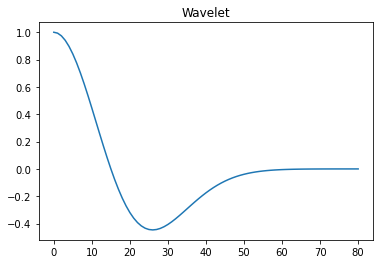

In [4]:
# draw wavelat
plt.plot(source_array)
plt.title('Wavelet')
plt.show()

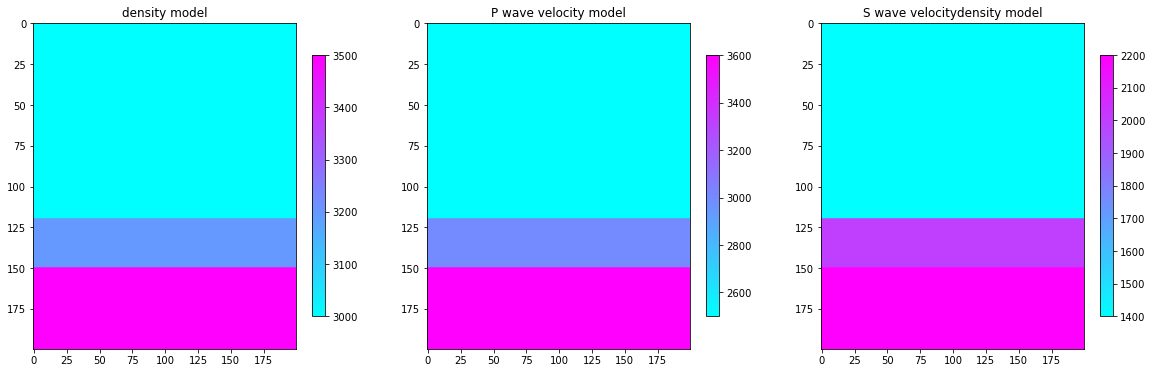

In [5]:
# draw model
test.DrawModel()

In [6]:
test.o22FM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

The 99 times result of v_x near the source position
[[ 0.01695512  0.06580268 -0.03728085  0.08537672 -0.03728085  0.06580268
   0.01695512]
 [-0.10708433  0.09293278 -0.11704519  0.08953454 -0.11704519  0.09293278
  -0.10708433]
 [ 0.04847012  0.0658709  -0.04480601  0.10775033 -0.04480601  0.0658709
   0.04847012]
 [-0.06327906  0.04593038 -0.07851667  0.0473168  -0.07851667  0.04593038
  -0.06327906]
 [ 0.04847012  0.0658709  -0.04480601  0.10775033 -0.04480601  0.0658709
   0.04847012]
 [-0.10708433  0.09293278 -0.11704519  0.08953454 -0.11704519  0.09293278
  -0.10708433]
 [ 0.01695512  0.06580268 -0.03728085  0.08537672 -0.03728085  0.06580268
   0.01695512]]
The 199 times result of v_x near the source position
[[ 0.05030461 -0.05024954  0.06391145 -0.05862983  0.06389504 -0.05007553
   0.05097667]
 [ 0.0189393  -0.0326006   0.02269856 -0.0318564   0.02272172 -0.03235899
   0.01972983]
 [ 0.05069337 -0.04698304  0.06527155 -0.05578402  0.06532008 -0.04669768
   0.05156027]
 [ 0.0

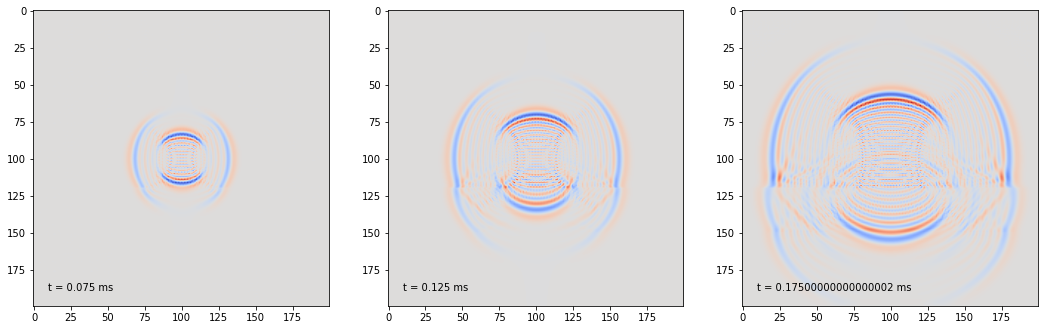

In [7]:
test.DrawXWaveField([150, 250, 350])

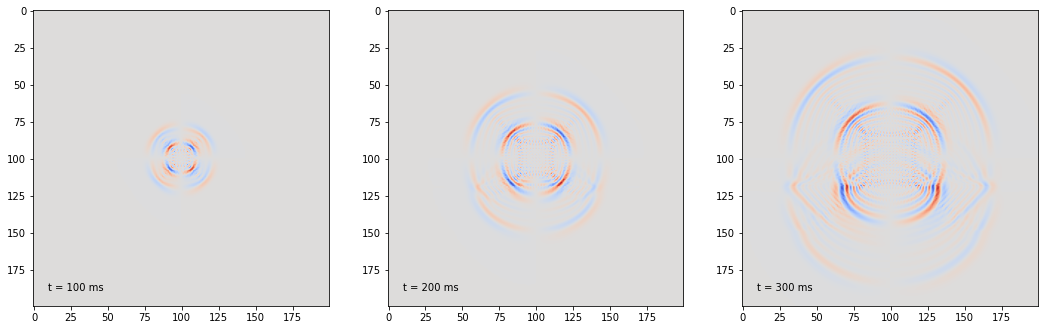

In [8]:
test.DrawZWaveField([100, 200, 300])

In [9]:
test_2 = FirstOlderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)
test_2.o4xFM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

The 99 times result of v_x near the source position
[[ 0.02945584 -0.02640723  0.00515431 -0.02037258  0.00515431 -0.02640723
   0.02945584]
 [ 0.08243466 -0.03146416  0.07715219 -0.02836002  0.07715219 -0.03146416
   0.08243466]
 [ 0.04827645 -0.05429026  0.03401822 -0.05254076  0.03401821 -0.05429027
   0.04827646]
 [ 0.09104027 -0.04498408  0.09073456 -0.04357862  0.09073456 -0.04498408
   0.09104027]
 [ 0.04827645 -0.05429026  0.03401822 -0.05254076  0.03401821 -0.05429027
   0.04827646]
 [ 0.08243466 -0.03146416  0.07715219 -0.02836002  0.07715219 -0.03146416
   0.08243466]
 [ 0.02945584 -0.02640723  0.00515431 -0.02037258  0.00515431 -0.02640723
   0.02945584]]
The 199 times result of v_x near the source position
[[ 0.01491002  0.00581554  0.01107701  0.0082815   0.0114564   0.00533449
   0.01329261]
 [-0.01093301 -0.00471593 -0.0143076  -0.00277264 -0.01407826 -0.00560279
  -0.01260891]
 [ 0.02597006 -0.00532692  0.02214798 -0.00249032  0.02226319 -0.00641222
   0.02419042]
 [-0

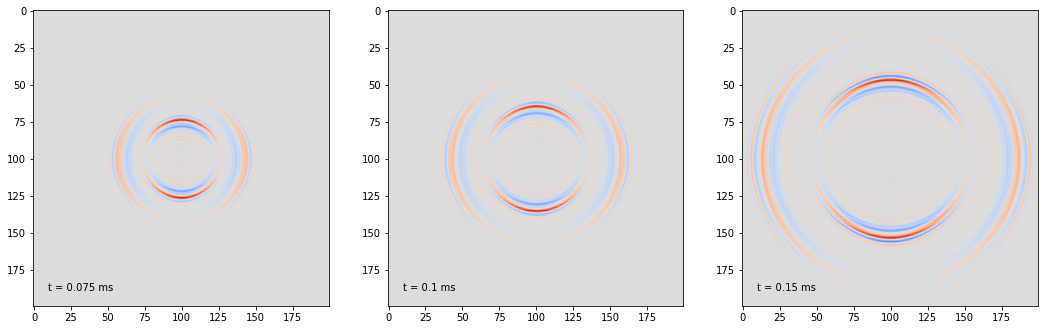

In [30]:
test_2.DrawXWaveField([150, 200, 300])

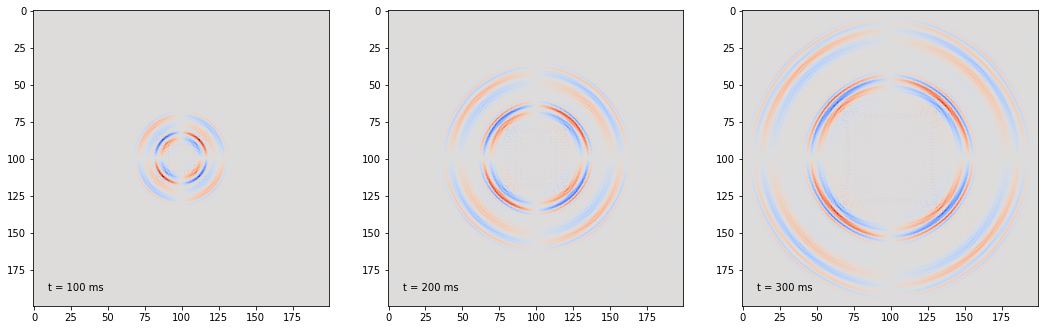

In [31]:
test_2.DrawZWaveField([100, 200, 300])

In [3]:
class FristOlderForward_PML(FirstOrderForward):
    # extra parameters
    _kai_x = None
    _kai_z = None
    _sigma_x = None
    _sigma_z = None
    _alpha_x = None
    _alpha_z = None
    _pml_x = 0
    _pml_z = 0
    def __init__(self, pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z):
        
        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the amplitude u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)
        
        # initial kai sigma alpha
        self._kai_x = kai_x
        self._kai_z = kai_z
        self._sigma_x = sigma_x
        self._sigma_z = sigma_z
        self._alpha_x = alpha_x
        self._alpha_z = alpha_z
        
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # a o(2,4) forward modeling
        t_array = np.arange(0, self._tmax, self._dt)
        
        # set auxiliary parameters
        u = np.zeros((nx,nz), dtype=float)
        v = np.zeros((nx,nz), dtype=float)
        r = np.zeros((nx,nz), dtype=float)
        t = np.zeros((nx,nz), dtype=float)
        h = np.zeros((nx,nz), dtype=float)
        
        omega_xx = np.zeros((nx,nz), dtype=float)
        omega_xz = np.zeros((nx,nz), dtype=float)
        omega_zx = np.zeros((nx,nz), dtype=float)
        omega_zz = np.zeros((nx,nz), dtype=float)
        phi_xx = np.zeros((nx,nz), dtype=float)
        phi_zz = np.zeros((nx,nz), dtype=float)
        phi_zx = np.zeros((nx,nz), dtype=float)
        phi_xz = np.zeros((nx,nz), dtype=float)

        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute

                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                print("====after compute====")
                # print(u[107:113,8:14])
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])       
                # update pml correction
                u -= self.o24Correction_u(u, v, r ,t ,h, omega_xx, omega_xz)
                v -= self.o24Correction_v(u, v, r, t, h, omega_zx, omega_zz)
                print("====after min=====")
                print(u[107:113,8:14])
                # update omega
                omega_xx = self.o24Update_Omega_xx(omega_xx, r)
                omega_xz = self.o24Update_Omega_xz(omega_xz, h)
                omega_zx = self.o24Update_Omega_zx(omega_zx, h)
                omega_zz = self.o24Update_Omega_zz(omega_zz, t)
                
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                # update pml correction
                r -= self.o24Correction_r(u, v, r, t, h, phi_xx, phi_zz)
                t -= self.o24Correction_t(u, v, r, t, h, phi_xx, phi_zz)
                h -= self.o24Correction_h(u, v, r, t, h, phi_zx, phi_xz)
                # update phi
                phi_xx = self.o24Update_Phi_xx(phi_xx, u)
                phi_zz = self.o24Update_Phi_zz(phi_zz, v)
                phi_zx = self.o24Update_Phi_zx(phi_zx, v)
                phi_xz = self.o24Update_Phi_xz(phi_xz, u)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    
                print("====after add source====")
                print(u[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                # print(u[wavalet_position[1], wavalet_position[0]])
                
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24Correction_u(self, u, v, r, t, h, omega_xx, omega_xz):
        kernal_1 = np.array([[0, 0, 0],[0, 1, 0],[0, -1, 0]])
        kernal_2 = np.array([[0, 0, 0],[0, 1, -1],[0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(r, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(h, kernal_2, mode='same')
        return u + self._dt / self._pmodel * (one + two + omega_xx + omega_xz)
    
    def o24Correction_v(self, u, v, r, t, h, omega_zx, omega_zz):
        kernal_1 = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]])
        kernal_2 = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(h, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(t, kernal_2, mode='same')
        return v + self._dt / self._pmodel *(one + two + omega_zx + omega_zz)
    
    def o24Correction_r(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c11 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c13 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return r + self._dt * (one + two)
    
    def o24Correction_t(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c13 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c11 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return t + self._dt * (one + two)
    
    def o24Correction_h(self, u, v, r, t, h, phi_zx, phi_xz):
        kernal_1 = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        kernal_2 = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = self._c44 * (phi_zx + (1 - 1 / self._kai_x) * convolve(v, kernal_1, mode='same'))
        two = self._c44 * (phi_xz + (1 - 1 / self._kai_z) * convolve(u, kernal_2, mode='same'))
        return h + self._dt * (one + two)
    
    def o24Update_Omega_xx(self, omega_xx, r):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_xx + a_x * convolve(r, kernal, mode='same') * 0.5
    
    def o24Update_Omega_xz(self, omega_xz, h):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_xz + a_z * convolve(h, kernal, mode='same') * 0.5
    
    def o24Update_Omega_zx(self, omega_zx, h):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_zx + a_x * convolve(h, kernal, mode='same') * 0.5

    def o24Update_Omega_zz(self, omega_zz, t):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_zz + a_z * convolve(t, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xx(self, phi_xx, u):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_xx + a_x * convolve(u, kernal, mode='same') * 0.5
 
    def o24Update_Phi_zz(self, phi_zz, v):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_zz + a_z * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_zx(self, phi_zx, v):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_zx + a_x * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xz(self, phi_xz, u):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_xz + a_z * convolve(u, kernal, mode='same') * 0.5
    
    # a easy version of setting auxiliary parameters 
    def Cal_Auxiliary_Para(vsmodel, nx, nz, xmax, zmax, pml_x, pml_z):
        kai_x = np.zeros((nx, nz), dtype=float)
        kai_z = np.zeros((nx, nz), dtype=float)
        sigma_x = np.zeros((nx, nz), dtype=float)
        sigma_z = np.zeros((nx, nz), dtype=float)
        alpha_x = np.zeros((nx, nz), dtype=float)
        alpha_z = np.zeros((nx, nz), dtype=float)
        # sigma_max = -np.max(vsmodel) * 3 * log10(0.00001) / (2 * sqrt((xmax / nx * pml_x)**2 + (zmax / nz * pml_z)**2))
        sigma_max = 1200
        alpha_max = 150
        kai_max = 2
        ratio = np.ones((nx, nz), dtype=float)
        for tx in range(nx):
            for tz in range(nz):
                if tx < pml_x and tz < pml_z:  # locating the left top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x and tz > nz - pml_z - 1: # locating the right top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x:  # middle top block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x - tx)

                elif tx > nx - pml_x - 1 and tz < pml_z:  # left bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx > nx - pml_x - 1 and tz > nz - pml_z - 1: # the right bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tz < pml_z: # the left middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z - tz)

                elif tz > nz - pml_z - 1: # the right middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z + tz - nz + 1)

                elif tx > nx - pml_x - 1: # the bottom middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x + tx - nx + 1)

                else:
                        ratio[tx, tz] = 0
        
        ratio = np.power(ratio, 2)
        
        sigma_x = sigma_max * ratio
        sigma_z = sigma_max * ratio
        
        alpha_x = alpha_max * ratio
        alpha_z = alpha_max * ratio
        
        kai_x = 1 + (kai_max - 1) * ratio
        kai_z = 1 + (kai_max - 1) * ratio

        return kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z